# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
use_gp=True
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [7]:
# test likelihood function
values=[0.5]
like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)

updated parameters, update theories
updated 0 linP parameters
updated 1 after mean flux parameters
updated 1 after thermal parameters
0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.82678076324723049, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.79400932502668009, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.75832916245871795, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12436389094838281}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.71997791172041337, 'gamma': 1.3999999999999999, 'si

-2976.1518412662795

In [8]:
#cProfile.run("like.get_chi2(linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
def log_prob(x,like,linP_Mpc_params):
    return like.log_prob(values=x,linP_Mpc_params=linP_Mpc_params)

In [10]:
like.go_silent()

In [11]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like,linP_Mpc_params) for x in xs]

-1.2 < ln_tau_0 < -0.7
0.301194211912 < tau_0 < 0.496585303791
0.608605317804 < <F> < 0.739934054784


Text(0, 0.5, '$\\chi^2$')

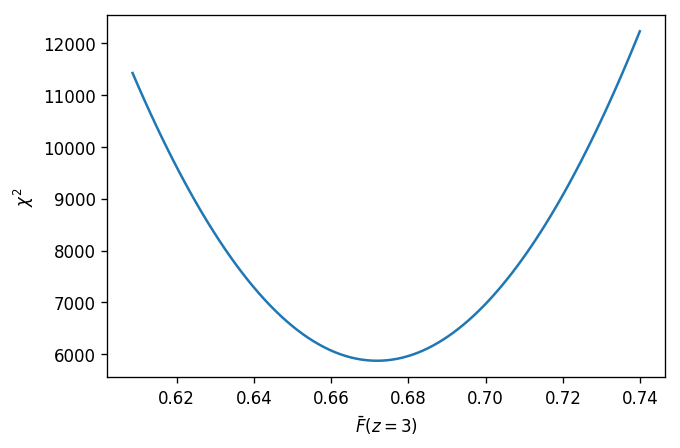

In [12]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [13]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [14]:
p0.flatten()

array([ 0.48589907,  0.7319621 ,  0.41257746,  0.87116564,  0.11344114,
        0.70979098,  0.85534595,  0.43048159,  0.88582473,  0.89859234])

In [15]:
# test function
log_prob(p0[0],like,linP_Mpc_params)

-2997.4669595096261

In [16]:
# setup sampler
emu.arxiv.verbose=False
emu.verbose=False
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like,linP_Mpc_params])

In [17]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.55105284  0.55764141  0.55822628  0.54981627  0.57000111  0.56158982
  0.561106    0.54972569  0.5661661   0.55561867] [-2938.6317606  -2938.42197617 -2938.45546842 -2938.79101821 -2940.94808237
 -2938.81358518 -2938.74469043 -2938.80416954 -2939.75481504 -2938.37175477]


In [18]:
# reset and run actual chains
sampler.reset()
nsteps=500
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0].flatten())

0 [ 0.55834654  0.56080945  0.55779401  0.5482634   0.56429358  0.56158982
  0.56031664  0.54770142  0.56769071  0.55561867]
100 [ 0.55526471  0.55244619  0.55819994  0.56551683  0.54990413  0.54613089
  0.55957374  0.55341096  0.56174329  0.55823781]
200 [ 0.55943234  0.55028787  0.55055029  0.55488778  0.56872026  0.54921519
  0.55657499  0.55453938  0.55466716  0.55310149]
300 [ 0.56151623  0.54935641  0.55146764  0.54910349  0.55322021  0.55293415
  0.5615805   0.55842626  0.55323915  0.56140775]
400 [ 0.55513907  0.54602714  0.55953811  0.55755137  0.55571137  0.54607035
  0.5553253   0.56159797  0.55076754  0.55813102]


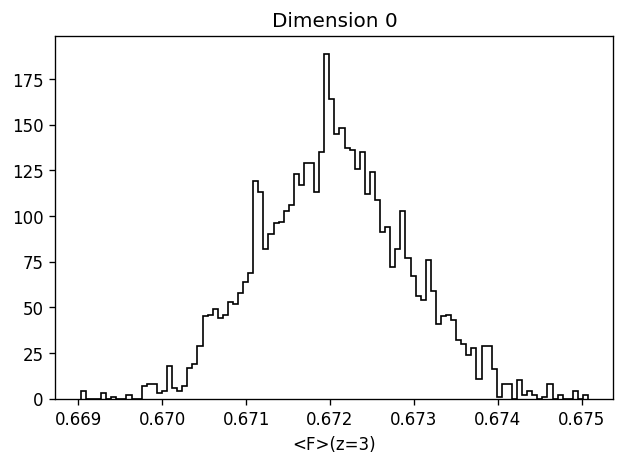

In [19]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [20]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.801


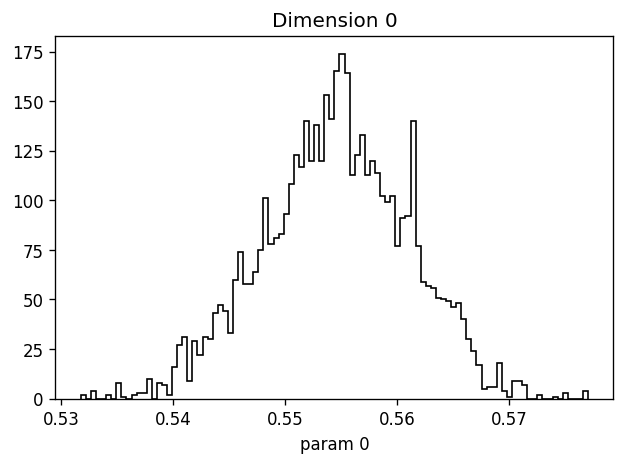

In [21]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))